# Sales Intelligence EDA
This notebook provides decision-oriented diagnostics for the CRO's question about win rate decline despite healthy pipeline volume.
Data source: `../data/skygeni_sales_data.csv`

In [7]:
# Imports and global settings
from __future__ import annotations

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

sns.set_theme(style="whitegrid", context="talk")

def format_percent(value: float, digits: int = 1) -> str:
    """Format a numeric value as a percentage string."""
    if pd.isna(value):
        return "N/A"
    return f"{value * 100:.{digits}f}%"

def plot_line(data: pd.DataFrame, x_col: str, y_col: str, title: str, y_label: str) -> None:
    """Simple reusable line plot."""
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=data, x=x_col, y=y_col, marker="o")
    plt.title(title)
    plt.xlabel("")
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_bar(data: pd.DataFrame, x_col: str, y_col: str, title: str, y_label: str) -> None:
    """Simple reusable bar plot."""
    plt.figure(figsize=(10, 5))
    sns.barplot(data=data, x=x_col, y=y_col)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 1. Data Loading & Cleaning
Assumptions for missing values:
- Missing `closed_date` implies open/unclosed deal; sales cycle remains `NaN`.
- Missing `deal_amount` is set to 0 to avoid inflating ACV; this is tracked via a flag.
- Missing categorical values are labeled as `Unknown` for consistent grouping.

In [8]:
data_path = "../data/skygeni_sales_data.csv"
df = pd.read_csv(data_path)

# Standardize column names for consistent access
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("-", "_", regex=False)
)

display(df.head())
print("Rows:", len(df))
print("Columns:", list(df.columns))

missing_before = df.isna().sum().sort_values(ascending=False)
display(missing_before[missing_before > 0])

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


Rows: 5000
Columns: ['deal_id', 'created_date', 'closed_date', 'sales_rep_id', 'industry', 'region', 'product_type', 'lead_source', 'deal_stage', 'deal_amount', 'sales_cycle_days', 'outcome']


Series([], dtype: int64)

In [9]:
# Parse dates
date_cols = ["created_date", "closed_date"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Numeric columns
numeric_cols = ["deal_amount", "sales_cycle_days"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Missing value handling
df["deal_amount_missing"] = df["deal_amount"].isna()
df["deal_amount"] = df["deal_amount"].fillna(0)

categorical_cols = [
    "industry",
    "region",
    "product_type",
    "lead_source",
    "deal_stage",
    "sales_rep_id",
    "outcome",
]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

missing_after = df.isna().sum().sort_values(ascending=False)
display(missing_after[missing_after > 0])

Series([], dtype: int64)

# 2. Feature Engineering

In [10]:
# Derive quarter from created_date
df["quarter"] = df["created_date"].dt.to_period("Q").astype(str)

# Recompute sales_cycle_days to ensure consistency
df["sales_cycle_days"] = (df["closed_date"] - df["created_date"]).dt.days
df.loc[df["sales_cycle_days"] < 0, "sales_cycle_days"] = np.nan

# Binary win indicator
df["is_won"] = (df["outcome"].str.lower() == "won").astype(int)
df["won_amount"] = np.where(df["is_won"] == 1, df["deal_amount"], 0)

display(df[["deal_id", "created_date", "closed_date", "quarter", "sales_cycle_days", "is_won"]].head())

,deal_id,created_date,closed_date,quarter,sales_cycle_days,is_won
0,D00001,2023-11-24,2023-12-15,2023Q4,21.0,1
1,D00002,2023-01-17,2023-01-27,2023Q1,10.0,1
2,D00003,2023-10-29,2023-12-10,2023Q4,42.0,0
3,D00004,2023-07-14,2023-08-02,2023Q3,19.0,1
4,D00005,2024-02-29,2024-05-26,2024Q1,87.0,0


# 3. Core Win Rate Diagnostics

,quarter,deal_count,total_acv,win_rate,avg_deal_size,avg_sales_cycle
0,2023Q1,1006,25286077,0.437376,25135.265408,64.648111
1,2023Q2,1014,27115555,0.442801,26741.178501,63.878698
2,2023Q3,1006,26375100,0.466203,26217.793241,62.360835
3,2023Q4,1013,26977557,0.479763,26631.349457,63.635735
4,2024Q1,961,25678175,0.436004,26720.265349,64.258065


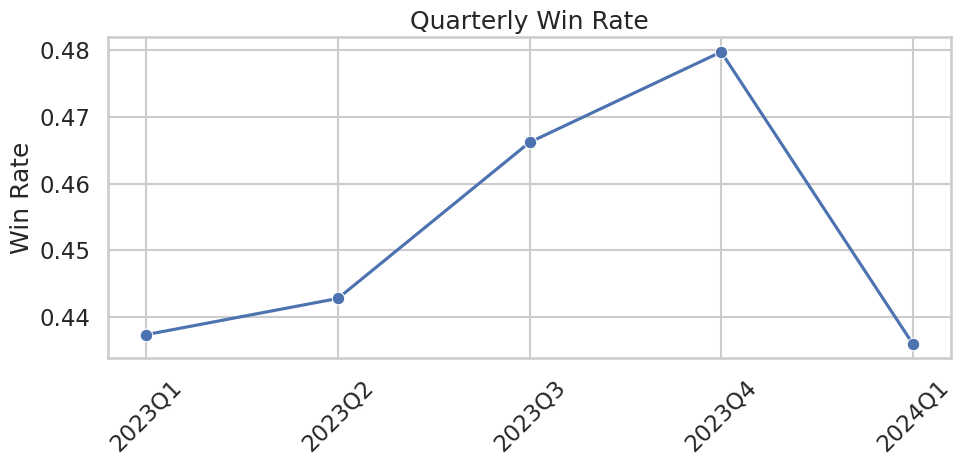

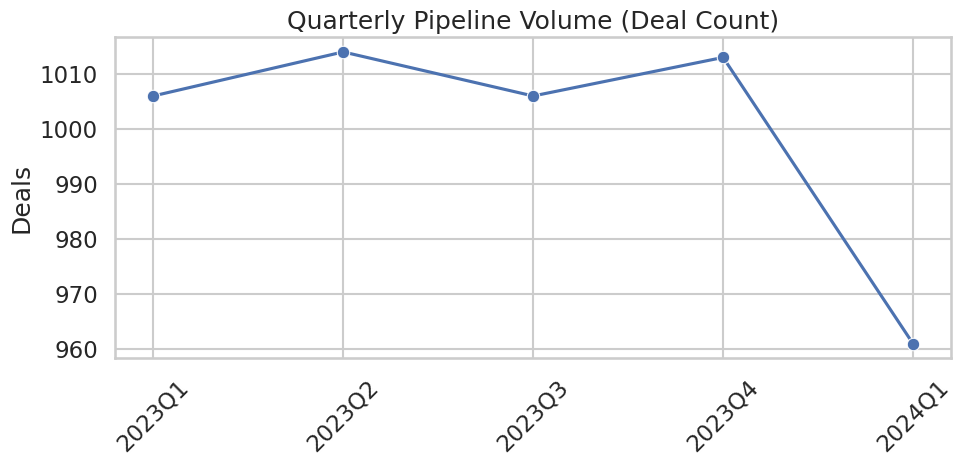

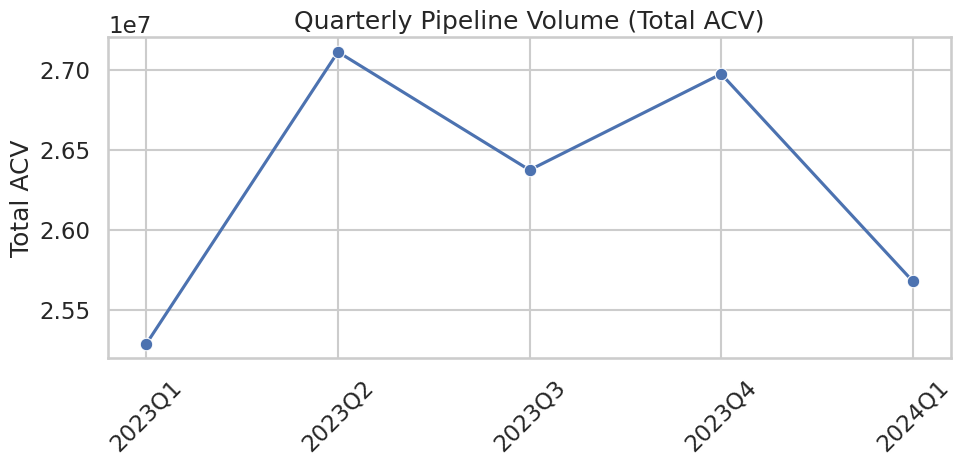

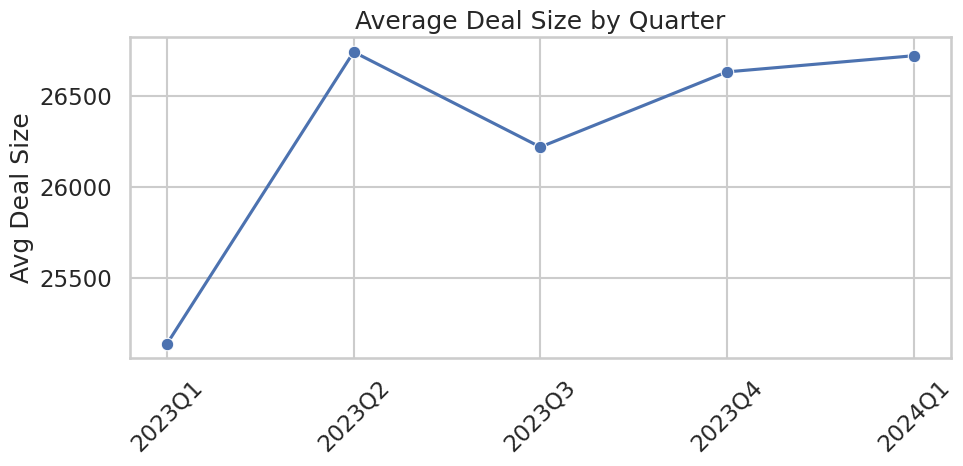

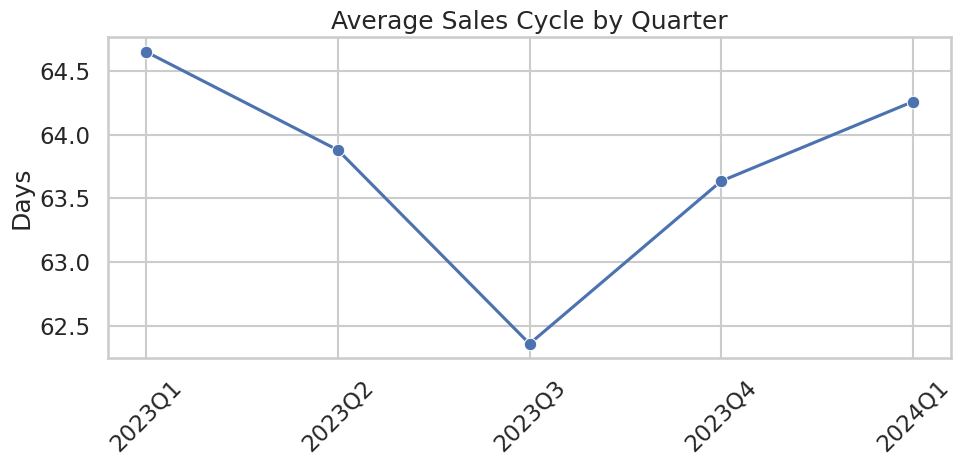

In [11]:
def summarize_quarterly(data: pd.DataFrame) -> pd.DataFrame:
    """Aggregate core metrics by quarter."""
    summary = (
        data.groupby("quarter", as_index=False)
        .agg(
            deal_count=("deal_id", "count"),
            total_acv=("deal_amount", "sum"),
            win_rate=("is_won", "mean"),
            avg_deal_size=("deal_amount", "mean"),
            avg_sales_cycle=("sales_cycle_days", "mean"),
)
        .sort_values("quarter")
    )
    return summary

quarterly = summarize_quarterly(df)
display(quarterly)

plot_line(quarterly, "quarter", "win_rate", "Quarterly Win Rate", "Win Rate")
plot_line(quarterly, "quarter", "deal_count", "Quarterly Pipeline Volume (Deal Count)", "Deals")
plot_line(quarterly, "quarter", "total_acv", "Quarterly Pipeline Volume (Total ACV)", "Total ACV")
plot_line(quarterly, "quarter", "avg_deal_size", "Average Deal Size by Quarter", "Avg Deal Size")
plot_line(quarterly, "quarter", "avg_sales_cycle", "Average Sales Cycle by Quarter", "Days")

Use the charts above to confirm whether win rate is falling while pipeline volume holds steady, and whether deal size or sales cycle changes are contributing drivers.

# 4. Segment-Level Analysis

,industry,deal_count,win_rate,avg_deal_size,avg_sales_cycle
0,Ecommerce,1060,0.449057,26626.355660,63.918868
3,HealthTech,1010,0.445545,25163.640594,63.465347
4,SaaS,1001,0.451548,26502.002997,64.619381
1,EdTech,992,0.441532,27346.715726,62.878024
2,FinTech,937,0.477054,25759.661686,63.869797


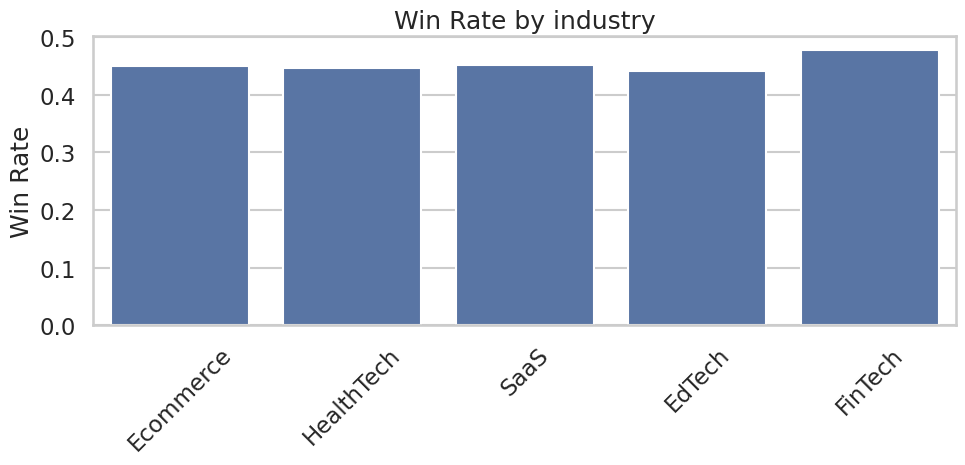

,region,deal_count,win_rate,avg_deal_size,avg_sales_cycle
2,India,1286,0.457232,26622.862364,64.384137
0,APAC,1242,0.449275,26291.356683,62.874396
3,North America,1239,0.447942,26054.147700,64.142857
1,Europe,1233,0.455799,26164.240876,63.583131


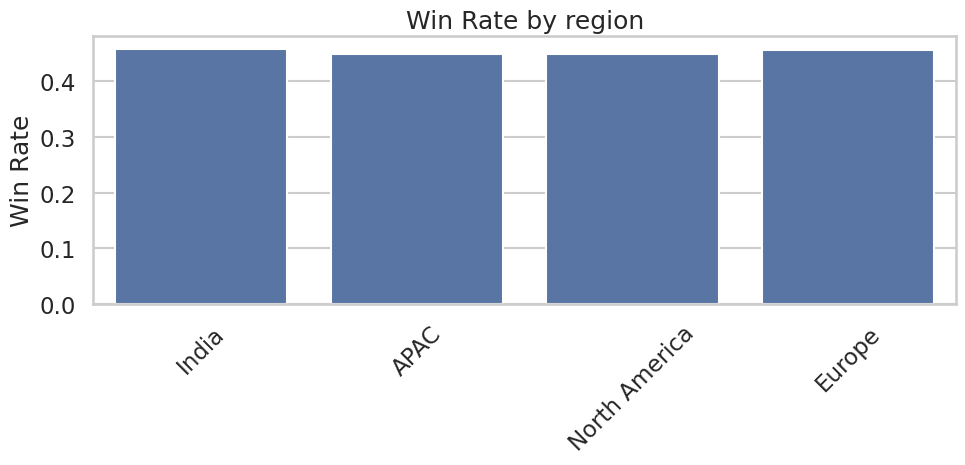

,product_type,deal_count,win_rate,avg_deal_size,avg_sales_cycle
0,Core,1694,0.455136,26436.738489,63.220189
2,Pro,1676,0.452864,26699.849642,63.810263
1,Enterprise,1630,0.449693,25705.325767,64.244172


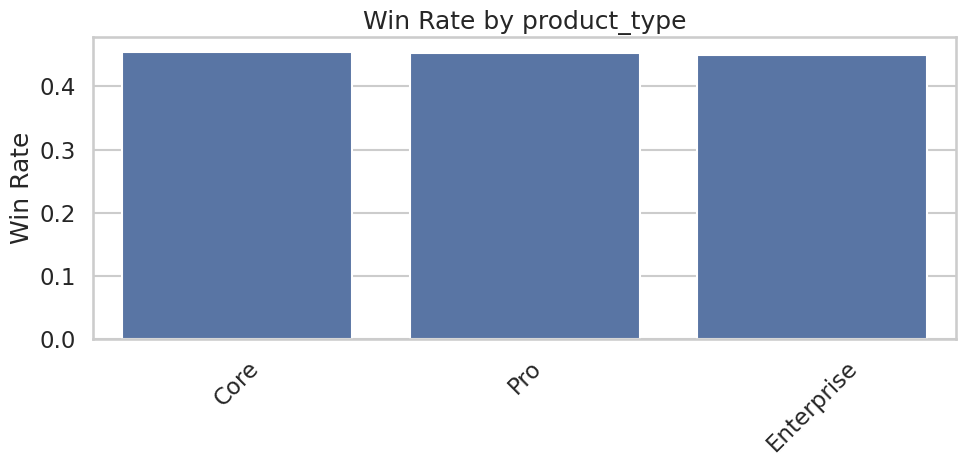

,lead_source,deal_count,win_rate,avg_deal_size,avg_sales_cycle
0,Inbound,1262,0.460380,27041.867670,63.682250
3,Referral,1252,0.455272,26261.345847,64.443291
1,Outbound,1246,0.455056,25963.354735,64.902087
2,Partner,1240,0.439516,25867.808065,61.968548


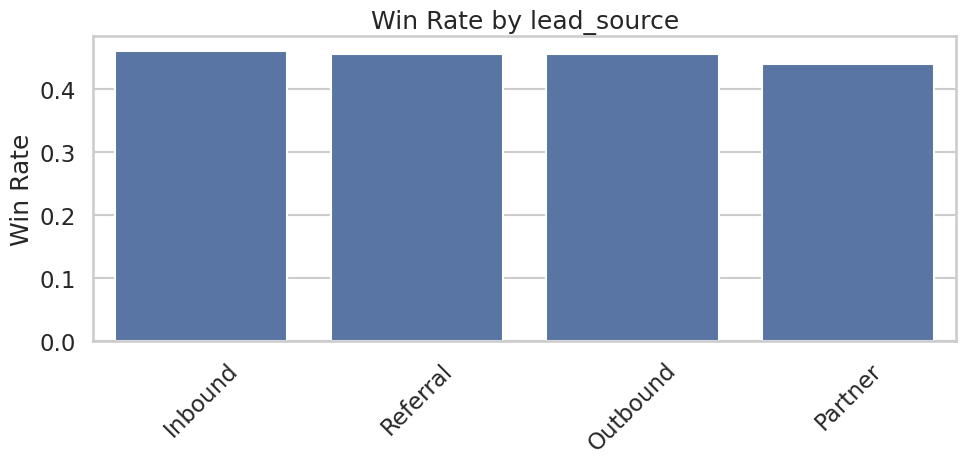

,sales_rep_id,deal_count,win_rate,avg_deal_size,avg_sales_cycle
12,rep_20,230,0.469565,27177.886957,62.034783
7,rep_16,223,0.470852,25545.623318,64.367713
11,rep_2,221,0.461538,28477.212670,60.330317
18,rep_3,216,0.472222,24243.740741,62.949074
14,rep_22,212,0.400943,21858.117925,63.603774
0,rep_1,211,0.454976,25240.521327,66.691943
13,rep_21,208,0.509615,23265.250000,65.336538
5,rep_14,207,0.439614,25350.396135,63.695652
17,rep_25,205,0.453659,26716.800000,59.707317
22,rep_7,204,0.416667,26684.926471,63.176471


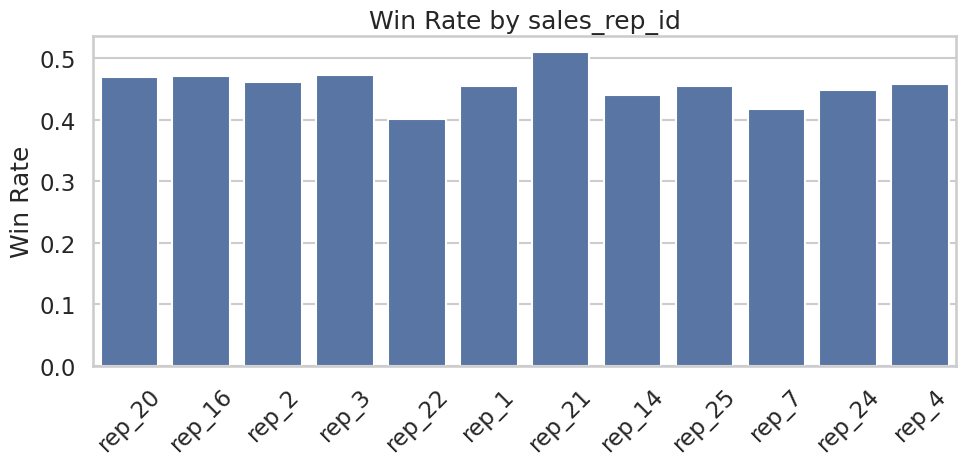

In [14]:
def segment_summary(data: pd.DataFrame, segment_col: str, top_n: int = 10) -> pd.DataFrame:
    """Compute win rate and supporting metrics by segment."""
    summary = (
        data.groupby(segment_col, as_index=False)
        .agg(
            deal_count=("deal_id", "count"),
            win_rate=("is_won", "mean"),
            avg_deal_size=("deal_amount", "mean"),
            avg_sales_cycle=("sales_cycle_days", "mean"),
        )
        .sort_values("deal_count", ascending=False)
    )
    return summary.head(top_n)

segment_columns = ["industry", "region", "product_type", "lead_source", "sales_rep_id"]

for col in segment_columns:
    segment_df = segment_summary(df, col, top_n=12)
    display(segment_df)
    plot_bar(segment_df, col, "win_rate", f"Win Rate by {col}", "Win Rate")

# 5. Custom Business Metrics
Two original metrics to diagnose win rate decline:
- **Pipeline Quality Index (PQI):** $PQI = \frac{\sum Won\ Amount}{\sum Total\ Amount}$
- **Rep Efficiency Score (RES):** $RES = \frac{Win\ Rate \times Avg\ Deal\ Size}{Avg\ Sales\ Cycle + 1}$

,quarter,total_amount,won_amount,pqi
0,2023Q1,25286077,10827410,0.428197
1,2023Q2,27115555,13055744,0.481485
2,2023Q3,26375100,12133745,0.460045
3,2023Q4,26977557,12882616,0.477531
4,2024Q1,25678175,11689763,0.455241


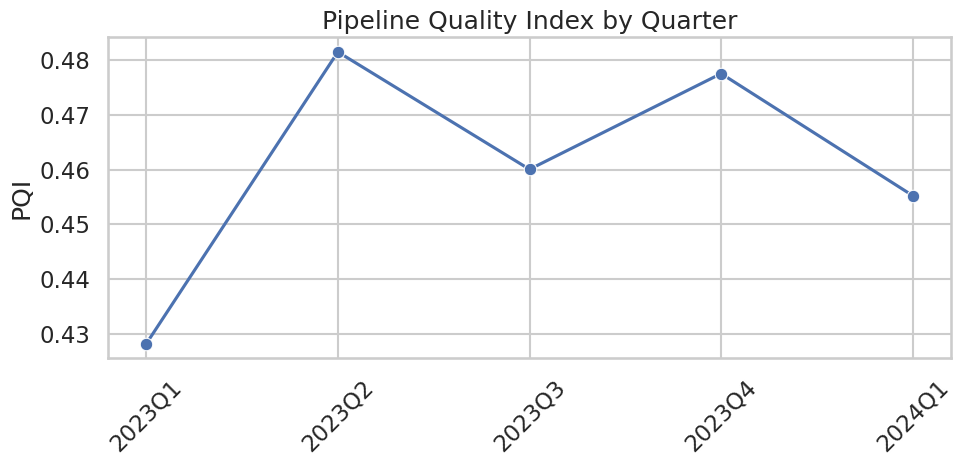

,sales_rep_id,deal_count,win_rate,avg_deal_size,avg_sales_cycle,res
3,rep_12,180,0.483333,30786.877778,59.672222,245.257611
11,rep_2,221,0.461538,28477.212670,60.330317,214.303947
8,rep_17,175,0.445714,29673.182857,60.868571,213.771891
2,rep_11,200,0.465000,30268.255000,66.710000,207.867945
12,rep_20,230,0.469565,27177.886957,62.034783,202.456324
17,rep_25,205,0.453659,26716.800000,59.707317,199.651458
20,rep_5,201,0.457711,28776.368159,65.263682,198.770619
10,rep_19,196,0.479592,27310.642857,65.132653,198.055889
21,rep_6,201,0.427861,30203.985075,64.781095,196.456112
23,rep_8,187,0.481283,26469.358289,65.171123,192.519981


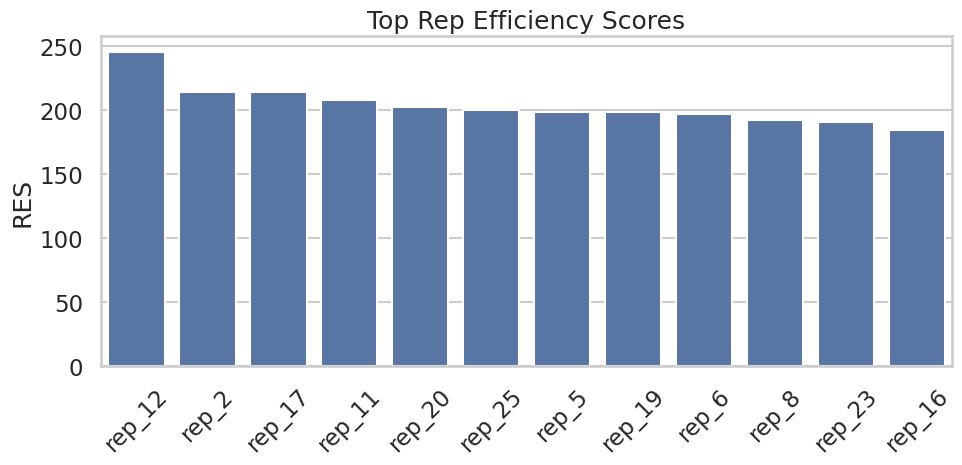

In [16]:
def pipeline_quality_index(data: pd.DataFrame, group_col: str) -> pd.DataFrame:
    """Weighted win rate by amount, indicating quality of pipeline dollars."""
    grouped = (
        data.groupby(group_col, as_index=False)
        .agg(
            total_amount=("deal_amount", "sum"),
            won_amount=("won_amount", "sum"),
        )
    )
    grouped["pqi"] = np.where(
        grouped["total_amount"] > 0, grouped["won_amount"] / grouped["total_amount"], np.nan
    )
    return grouped.sort_values(group_col)

def rep_efficiency_score(data: pd.DataFrame) -> pd.DataFrame:
    """Blend win rate, deal size, and speed to identify efficient reps."""
    summary = (
        data.groupby("sales_rep_id", as_index=False)
        .agg(
            deal_count=("deal_id", "count"),
            win_rate=("is_won", "mean"),
            avg_deal_size=("deal_amount", "mean"),
            avg_sales_cycle=("sales_cycle_days", "mean"),
        )
    )
    summary["res"] = (
        summary["win_rate"] * summary["avg_deal_size"] / (summary["avg_sales_cycle"].fillna(0) + 1)
    )
    return summary.sort_values("res", ascending=False)

pqi_by_quarter = pipeline_quality_index(df, "quarter")
display(pqi_by_quarter)
plot_line(pqi_by_quarter, "quarter", "pqi", "Pipeline Quality Index by Quarter", "PQI")

rep_efficiency = rep_efficiency_score(df)
display(rep_efficiency.head(12))
plot_bar(rep_efficiency.head(12), "sales_rep_id", "res", "Top Rep Efficiency Scores", "RES")

**How to use these metrics**
- PQI highlights whether large-dollar pipeline is converting; a falling PQI signals that bigger deals are stalling or losing.
- RES identifies reps who win bigger deals faster; use it to share playbooks, rebalance territories, or target coaching.

# 6. Key Business Insights Summary

In [17]:
# Build a few data-backed insights dynamically
quarterly_sorted = quarterly.sort_values("quarter").reset_index(drop=True)
recent_quarters = quarterly_sorted.tail(2)

if len(recent_quarters) == 2:
    q_prev = recent_quarters.iloc[0]
    q_last = recent_quarters.iloc[1]
    win_rate_change = q_last["win_rate"] - q_prev["win_rate"]
    deal_count_change = q_last["deal_count"] - q_prev["deal_count"]
    cycle_change = q_last["avg_sales_cycle"] - q_prev["avg_sales_cycle"]
else:
    q_prev = q_last = None
    win_rate_change = deal_count_change = cycle_change = np.nan

region_summary = (
    df.groupby("region", as_index=False)
    .agg(deal_count=("deal_id", "count"), win_rate=("is_won", "mean"))
    .query("deal_count >= 10")
    .sort_values("win_rate")
)
lowest_region = region_summary.iloc[0] if not region_summary.empty else None

pqi_recent = pqi_by_quarter.tail(2)
pqi_change = (
    pqi_recent.iloc[1]["pqi"] - pqi_recent.iloc[0]["pqi"]
    if len(pqi_recent) == 2
    else np.nan
)

insights_md = []
if q_last is not None:
    insights_md.append(
        f"- **Finding:** Win rate changed by {format_percent(win_rate_change)} quarter-over-quarter while pipeline volume shifted by {deal_count_change:+.0f} deals.\n"
        f"  **Why it matters:** The issue is conversion efficiency, not just lead flow.\n"
        f"  **Recommended action:** Audit stage-by-stage drop-offs in the lowest-performing segments and tighten qualification criteria."
    )
    insights_md.append(
        f"- **Finding:** Average sales cycle shifted by {cycle_change:+.1f} days in the last quarter.\n"
        f"  **Why it matters:** Longer cycles reduce throughput and can depress win rates.\n"
        f"  **Recommended action:** Add deal reviews for stalled opportunities and reinforce time-bound next steps."
    )
if lowest_region is not None:
    insights_md.append(
        f"- **Finding:** {lowest_region['region']} has the lowest win rate at {format_percent(lowest_region['win_rate'])} across {lowest_region['deal_count']} deals.\n"
        f"  **Why it matters:** A regional performance gap can drag overall win rate even with healthy top-of-funnel.\n"
        f"  **Recommended action:** Reallocate enablement and senior support to that region and review product-market fit signals."
    )
else:
    insights_md.append(
        "- **Finding:** Some regions lack enough deal volume for reliable comparisons.\n"
        "  **Why it matters:** Decisions on resourcing could be misleading without stable sample sizes.\n"
        "  **Recommended action:** Set minimum volume thresholds before changing territory strategy."
    )
if pd.notna(pqi_change):
    insights_md.append(
        f"- **Finding:** Pipeline Quality Index changed by {format_percent(pqi_change)} in the last quarter.\n"
        f"  **Why it matters:** Large-dollar opportunities may be slipping, not just small deals.\n"
        f"  **Recommended action:** Prioritize executive sponsorship and multi-threading on the largest opportunities."
    )

display(Markdown("\n\n".join(insights_md[:3])))

- **Finding:** Win rate changed by -4.4% quarter-over-quarter while pipeline volume shifted by -52 deals.
  **Why it matters:** The issue is conversion efficiency, not just lead flow.
  **Recommended action:** Audit stage-by-stage drop-offs in the lowest-performing segments and tighten qualification criteria.

- **Finding:** Average sales cycle shifted by +0.6 days in the last quarter.
  **Why it matters:** Longer cycles reduce throughput and can depress win rates.
  **Recommended action:** Add deal reviews for stalled opportunities and reinforce time-bound next steps.

- **Finding:** North America has the lowest win rate at 44.8% across 1239 deals.
  **Why it matters:** A regional performance gap can drag overall win rate even with healthy top-of-funnel.
  **Recommended action:** Reallocate enablement and senior support to that region and review product-market fit signals.